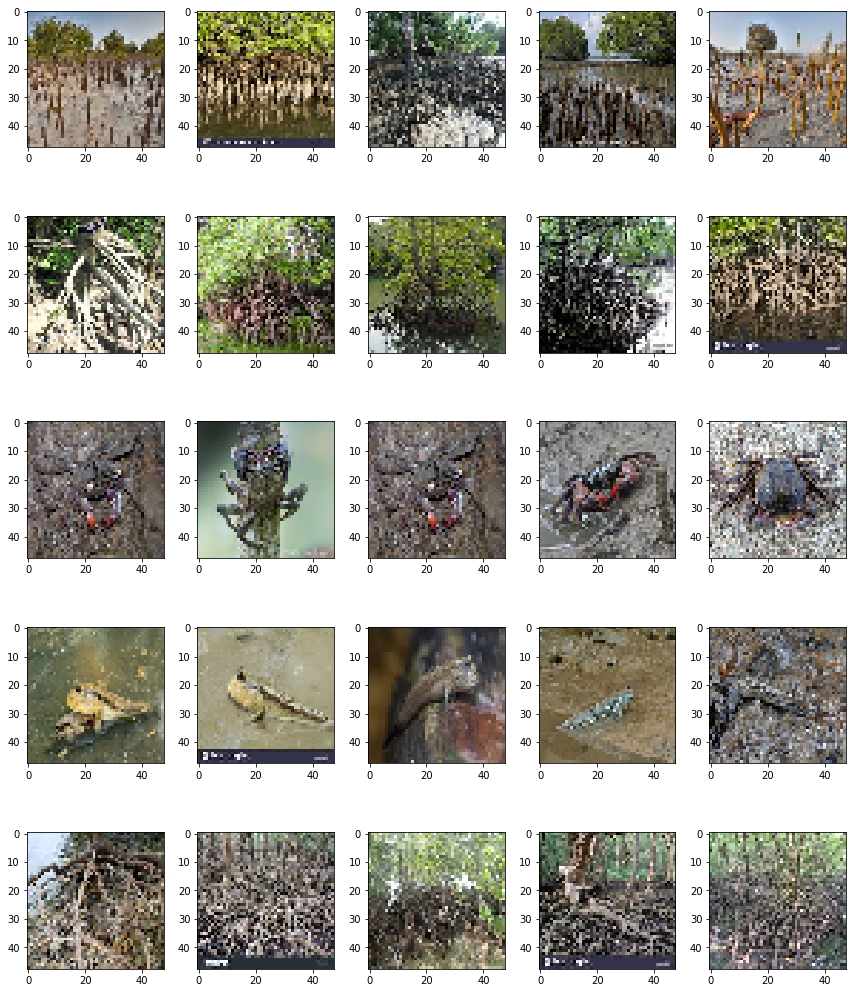

In [3]:
# https://towardsdatascience.com/from-raw-images-to-real-time-predictions-with-deep-learning-ddbbda1be0e4
# display some images for every different expression

import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# size of the image: 48*48 pixels
pic_size = 48

# input path for the images
base_path = "v_data/"

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train/"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" + os.listdir(base_path + "train/" + expression)[i*2], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
# for expression in os.listdir(base_path + "validation/"):
#     for i in range(10):
#         img = Image.open(base_path + "validation/" + expression + "/" + os.listdir(base_path + "validation/" + expression)[i])
#         img.save(base_path + "validation/" + expression + "/" + os.listdir(base_path + "validation/" + expression)[i][:-5]+'.jpeg')

In [7]:
from keras.preprocessing.image import ImageDataGenerator

# number of images to feed into the NN for every batch
batch_size = 64

datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

train_generator = datagen_train.flow_from_directory(base_path + "train",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory(base_path + "validation",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 125 images belonging to 5 classes.
Found 25 images belonging to 5 classes.


In [5]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 5

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(pic_size, pic_size,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# number of epochs to train the NN
epochs = 10

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/10
1/1 [==============================] - 10s 10s/step - loss: 2.2704 - acc: 0.1639 - val_loss: 1.5872 - val_acc: 0.2800

Epoch 00001: val_acc improved from -inf to 0.28000, saving model to model_weights.h5
Epoch 2/10
1/1 [==============================] - 8s 8s/step - loss: 2.1427 - acc: 0.2500 - val_loss: 1.5617 - val_acc: 0.4000

Epoch 00002: val_acc improved from 0.28000 to 0.40000, saving model to model_weights.h5
Epoch 3/10
1/1 [==============================] - 8s 8s/step - loss: 1.8868 - acc: 0.1875 - val_loss: 1.5388 - val_acc: 0.4000

Epoch 00003: val_acc did not improve from 0.40000
Epoch 4/10
1/1 [==============================] - 7s 7s/step - loss: 2.0936 - acc: 0.2623 - val_loss: 1.5126 - val_acc: 0.3600

Epoch 00004: val_acc did not improve from 0.40000
Epoch 5/10
1/1 [==============================] - 8s 8s/step - loss: 1.8096 - acc: 0.3438 - val_loss: 1.4897 - val_acc: 0.3600

Epoch 00005: val_acc did not improve from 0.40000
Epoch 6/10
1/1 [===================

In [9]:
# serialize model structure to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

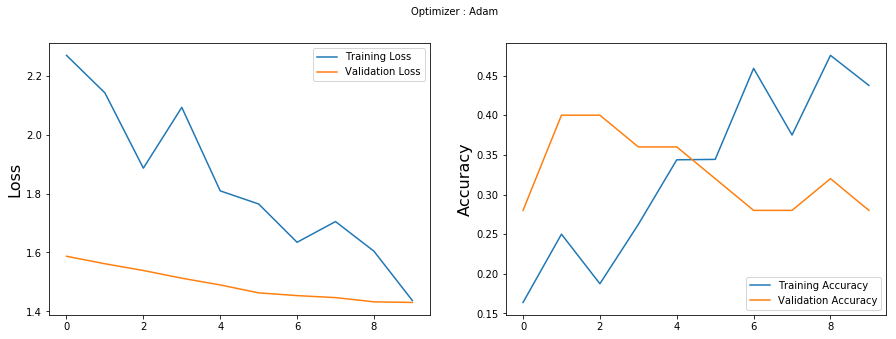

In [10]:
# plot the evolution of Loss and Acuracy on the train and validation sets

import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

<Figure size 432x288 with 0 Axes>

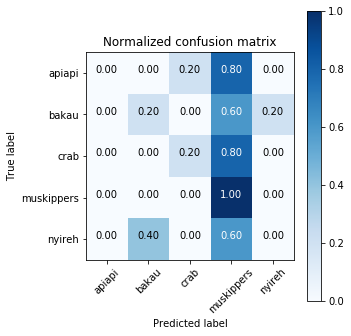

In [11]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

In [12]:
from keras.models import model_from_json
import numpy as np

class Model(object):

    LABEL_LIST = ["apiapi", "bakau", "crab", "mudskippers", "nyireh"]

    def __init__(self, model_json_file, model_weights_file):
        # load model from JSON file
        with open(model_json_file, "r") as json_file:
            loaded_model_json = json_file.read()
            self.loaded_model = model_from_json(loaded_model_json)

        # load weights into the new model
        self.loaded_model.load_weights(model_weights_file)
        self.loaded_model._make_predict_function()

    def predict_labels(self, img):
        self.preds = self.loaded_model.predict(img)
        return Model.LABEL_LIST[np.argmax(self.preds)], self.preds[0][np.argmax(self.preds)]

In [16]:
import tensorflow
from keras.preprocessing import image

model = Model("model.json", "model_weights.h5")

for i in range (25):
    img = image.load_img(base_path + "test/{}.jpeg".format(i+1), target_size=(pic_size, pic_size), color_mode="grayscale")
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    pred = model.predict_labels(img)
    print(pred)

('bakau', 0.3262084)
('bakau', 0.3286618)
('mudskippers', 0.2843341)
('bakau', 0.26335767)
('mudskippers', 0.30936006)
('bakau', 0.29016832)
('bakau', 0.29285234)
('bakau', 0.32976595)
('crab', 0.266817)
('apiapi', 0.24435684)
('mudskippers', 0.30854326)
('bakau', 0.2963482)
('bakau', 0.30259898)
('nyireh', 0.2265823)
('mudskippers', 0.2883056)
('mudskippers', 0.32291442)
('mudskippers', 0.2530755)
('mudskippers', 0.37863556)
('mudskippers', 0.3400974)
('mudskippers', 0.37306926)
('bakau', 0.34514648)
('bakau', 0.32836556)
('bakau', 0.3494017)
('bakau', 0.23666129)
('bakau', 0.35093352)


In [18]:
import tensorflow
from keras.preprocessing import image

model = Model("model.json", "model_weights.h5")

img = image.load_img(base_path + "test/1.jpeg", target_size=(pic_size, pic_size), color_mode="grayscale")
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)

pred = model.predict_labels(img)
pred

('mudskippers', 0.25035408)